In [22]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsemble
from mlens.visualization import corrmat
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             accuracy_score, roc_curve,
                             precision_recall_curve, f1_score)
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from keras import models, layers, optimizers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.calibration import CalibratedClassifierCV

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")

#Avoid future warnings: 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [23]:
df = pd.read_csv('Final_CV.csv')

In [24]:
# Check both the datatypes and if there is missing values
print(f"Data types:\n{11 * '-'}")
print(f"{df.dtypes}\n")
print(f"Sum of null values in each feature:\n{35 * '-'}")
print(f"{df.isnull().sum()}")
df.head()

Data types:
-----------
cus_Gender                    object
cus_MartialTypeId              int64
cus_Dependants               float64
cus_CurrenResTypeId            int64
cus_CurrenStyYear            float64
cus_Age                      float64
IndustryType                   int64
CustomerProfile                int64
CustomerSegment                int64
app_CustLoadTypeId            object
MarketNoofYearsinBusiness    float64
app_CustAssetValue           float64
app_CustProductCatTypeId       int64
app_CustBrandTypeId            int64
app_CustTenure               float64
app_CustInstalCount          float64
app_CustChasAsset            float64
app_CustChasInitial          float64
app_CustChasFinance          float64
app_CustFinanInterest        float64
app_CustEMI                  float64
app_CustGrossLoan            float64
app_CustViaIncomEstIncPm     float64
app_CustViaExpTotExpense     float64
app_CustViaGrossSurplus      float64
app_CustUVAge                float64
avg_clobal    

,cus_Gender,cus_MartialTypeId,cus_Dependants,cus_CurrenResTypeId,cus_CurrenStyYear,cus_Age,IndustryType,CustomerProfile,CustomerSegment,app_CustLoadTypeId,...,app_CustUVAge,avg_clobal,Score,AnotherScore,Loan_to_Value,Collateral,Overdue,Banking,Earning Potential,Label
0,M,2750,2.0,2755,15.0,NaN,605,2693,2695,566,...,0.0,84432.11,599.0,674.0,0,0,0,50,80,Pay
1,M,2750,4.0,2755,4.0,NaN,605,2693,2695,569,...,NaN,575730.28,NaN,NaN,0,0,100,50,80,Pay
2,M,2750,4.0,2755,4.0,NaN,605,2693,2695,569,...,NaN,575730.28,NaN,NaN,0,0,100,-50,80,Pay
3,M,2750,4.0,2755,4.0,NaN,605,2693,2695,569,...,NaN,575730.28,NaN,NaN,0,0,100,0,80,Pay
4,M,2750,4.0,2755,4.0,NaN,605,2693,2695,569,...,NaN,575730.28,NaN,NaN,0,0,0,0,80,Pay


In [26]:
df.app_CustLoadTypeId[df.app_CustLoadTypeId == '-'] = np.nan

C:\Users\ESFITA-USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
df.app_CustLoadTypeId.fillna(df.app_CustLoadTypeId.value_counts().index[0],inplace=True)

In [29]:
df.app_CustBrandTypeId.value_counts()

564     774
565      92
743      42
1659     16
1778     13
744       8
904       8
1638      6
1433      5
1864      5
1816      5
1760      5
739       4
1872      4
1985      4
1693      4
1639      3
1623      3
1501      3
1781      3
1681      2
1377      2
2424      2
723       2
740       2
2886      2
2143      2
1768      1
1380      1
2149      1
2399      1
2420      1
1710      1
1868      1
1861      1
1620      1
1848      1
1476      1
741       1
1839      1
1758      1
745       1
749       1
1416      1
815       1
819       1
2818      1
Name: app_CustBrandTypeId, dtype: int64

In [30]:
#Converting the text label into integers:
def cate(val):
    """
    This function is used to converting string classes into integer values.
    """
    if val == 'Pay':
        return 0
    else:
        return 1

#Applying a function cate:
df['Label'] = df['Label'].apply(cate)

Positive examples = 400
Negative examples = 641
Proportion of positive to negative examples = 62.40%


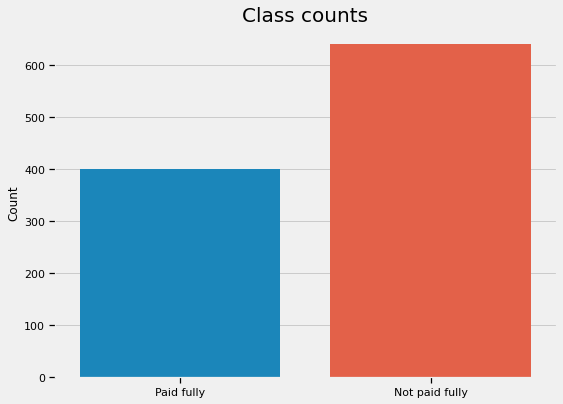

In [31]:
# Get number of positve and negative examples
neg = df[df["Label"] == 1].shape[0]
pos = df[df["Label"] == 0].shape[0]
print(f"Positive examples = {pos}")
print(f"Negative examples = {neg}")
print(f"Proportion of positive to negative examples = {(pos / neg) * 100:.2f}%")
plt.figure(figsize=(8, 6))
sns.countplot(df.Label)
plt.xticks((0, 1), ["Paid fully", "Not paid fully"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y=1, fontdict={"fontsize": 20});
plt.savefig('data_cv.jpg', bbox_inches='tight')

In [32]:
# Create dummy variables from the feature purpose
df = pd.get_dummies(df, columns=["cus_Gender"])
df.head()

,cus_MartialTypeId,cus_Dependants,cus_CurrenResTypeId,cus_CurrenStyYear,cus_Age,IndustryType,CustomerProfile,CustomerSegment,app_CustLoadTypeId,MarketNoofYearsinBusiness,...,Score,AnotherScore,Loan_to_Value,Collateral,Overdue,Banking,Earning Potential,Label,cus_Gender_F,cus_Gender_M
0,2750,2.0,2755,15.0,NaN,605,2693,2695,566,NaN,...,599.0,674.0,0,0,0,50,80,0,0,1
1,2750,4.0,2755,4.0,NaN,605,2693,2695,569,NaN,...,NaN,NaN,0,0,100,50,80,0,0,1
2,2750,4.0,2755,4.0,NaN,605,2693,2695,569,NaN,...,NaN,NaN,0,0,100,-50,80,0,0,1
3,2750,4.0,2755,4.0,NaN,605,2693,2695,569,NaN,...,NaN,NaN,0,0,100,0,80,0,0,1
4,2750,4.0,2755,4.0,NaN,605,2693,2695,569,NaN,...,NaN,NaN,0,0,0,0,80,0,0,1


In [33]:
df.columns

Index(['cus_MartialTypeId', 'cus_Dependants', 'cus_CurrenResTypeId',
       'cus_CurrenStyYear', 'cus_Age', 'IndustryType', 'CustomerProfile',
       'CustomerSegment', 'app_CustLoadTypeId', 'MarketNoofYearsinBusiness',
       'app_CustAssetValue', 'app_CustProductCatTypeId', 'app_CustBrandTypeId',
       'app_CustTenure', 'app_CustInstalCount', 'app_CustChasAsset',
       'app_CustChasInitial', 'app_CustChasFinance', 'app_CustFinanInterest',
       'app_CustEMI', 'app_CustGrossLoan', 'app_CustViaIncomEstIncPm',
       'app_CustViaExpTotExpense', 'app_CustViaGrossSurplus', 'app_CustUVAge',
       'avg_clobal', 'Score', 'AnotherScore', 'Loan_to_Value', 'Collateral',
       'Overdue', 'Banking', 'Earning Potential', 'Label', 'cus_Gender_F',
       'cus_Gender_M'],
      dtype='object')

In [34]:
# Original Data
X = df.loc[:, df.columns != "Label"].values
y = df.loc[:, df.columns == "Label"].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
print(f"Original data shapes: {X_train.shape, X_test.shape}")

Original data shapes: ((832, 35), (209, 35))


In [35]:
# Build random forest classifier (same config)
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.25,
                                criterion="entropy",
                                class_weight="balanced")

# Build model with no sampling
pip_orig = make_pipeline(Imputer(strategy="median"),rf_clf)
scores = cross_val_score(pip_orig,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Original model's average AUC: {scores.mean():.3f}")

# Build model with undersampling
pip_undersample = imb_make_pipeline(Imputer(strategy="median"),RandomUnderSampler(), rf_clf)
scores = cross_val_score(pip_undersample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Under-sampled model's average AUC: {scores.mean():.3f}")

# Build model with oversampling
pip_oversample = imb_make_pipeline(Imputer(strategy="median"),RandomOverSampler(), rf_clf)
scores = cross_val_score(pip_oversample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Over-sampled model's average AUC: {scores.mean():.3f}")

# Build model with EasyEnsemble
resampled_rf = BalancedBaggingClassifier(base_estimator=rf_clf,
                                         n_estimators=10, random_state=123)
pip_resampled = make_pipeline(Imputer(strategy="median"),resampled_rf)
                             
scores = cross_val_score(pip_resampled,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"EasyEnsemble model's average AUC: {scores.mean():.3f}")

# Build model with SMOTE
pip_smote = imb_make_pipeline(Imputer(strategy="median"),SMOTE(), rf_clf)
scores = cross_val_score(pip_smote,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"SMOTE model's average AUC: {scores.mean():.3f}")

Original model's average AUC: 0.825
Under-sampled model's average AUC: 0.807
Over-sampled model's average AUC: 0.820
EasyEnsemble model's average AUC: 0.812
SMOTE model's average AUC: 0.821


In [36]:
# Impute the missing data using features means
imp = Imputer(strategy="median")
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)


# Implement RandomOverSampler
sampler = SMOTE()
X_res, y_res = sampler.fit_sample(X_train, y_train)
# Shuffle the data
perms = np.random.permutation(X_res.shape[0])
X_res = X_res[perms]
y_res = y_res[perms]
X_res.shape, y_res.shape

((1024, 35), (1024,))

In [37]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [38]:
from sklearn.model_selection import RandomizedSearchCV
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
grid = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 100,scoring='roc_auc' ,cv = 10, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
grid.fit(X_res, y_res)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 42.8min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
              

In [39]:
print("Area Under Curve on Cross Validation Data:%.2f" % (grid.best_score_*100))
p = grid.best_params_
print(p)

Area Under Curve on Cross Validation Data:89.84
{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}


In [54]:
# Evaluate a model with optimized parameters:
best_rf = RandomForestClassifier(random_state = 42,n_estimators=350, min_samples_split= 2, min_samples_leaf=2, max_features='sqrt', max_depth=110, bootstrap = False)
#best_rf = grid.best_estimator_
best_rf.fit(X_res,y_res)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

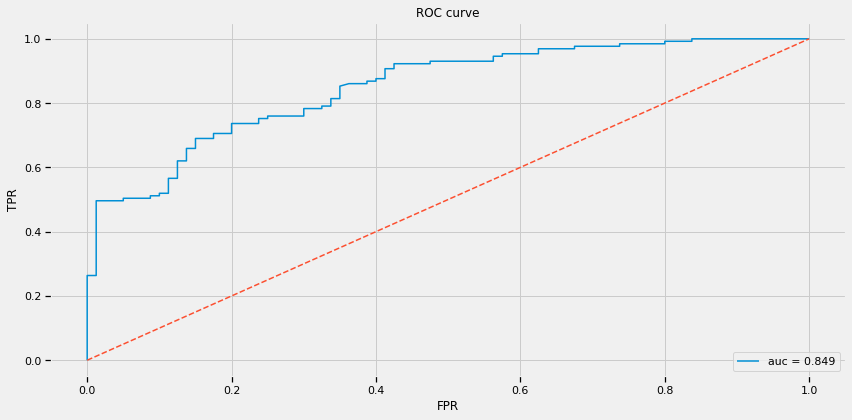

In [55]:
probs = best_rf.predict_proba(X_test)[:, 1:]
auc_score = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, label=f"auc = {auc_score:.3f}")
plt.plot([0,1],[0,1],'--')
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.tight_layout()
plt.savefig('auc_cv.jpg', bbox_inches='tight')

In [56]:
from collections import Counter 
Counter(y_test)

Counter({1: 129, 0: 80})

<Figure size 1152x576 with 0 Axes>

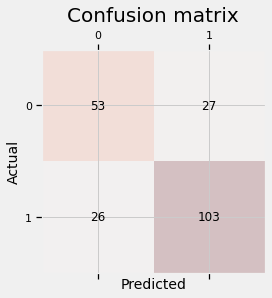

In [57]:
probs = best_rf.predict_proba(X_test)
preds = best_rf.predict(X_test)
conf_mat = confusion_matrix(y_test, preds)
# Define figure size and figure ratios
plt.figure(figsize=(16, 8))
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14})
plt.savefig('cm_cv.jpg', bbox_inches='tight')

In [58]:
#Generating sample status:
sample_weight = np.random.RandomState(42).rand(y.shape[0])
sw_train,sw_test = train_test_split(sample_weight,test_size=0.2)

In [64]:
#Caluculating Probability of 1 for a test data:
clf_isotonic = CalibratedClassifierCV(best_rf,cv=10,method='sigmoid')
clf_isotonic.fit(X_train,y_train,sw_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:,-1]

In [65]:
# Saving model to disk
pickle.dump(clf_isotonic, open('model_cv_sig.pkl','wb'))

In [31]:
#Making results:
for i in prob_pos_isotonic.argsort():
    print("Predicted_Value:{} Actual_Value:{} Probablity of Pay:{}".format(best_rf.predict(X_test[i].reshape(1,27)),y_test[i],(1-(clf_isotonic.predict_proba(X_test[i].reshape(1,27))[:,-1]))))

Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[1.]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[1.]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[1.]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[1.]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[1.]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.99646526]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.97500997]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.96674394]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.96361195]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.94805603]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.93388087]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.91472195]
Predicted_Value:[0] Actual_Value:1 Probablity of Pay:[0.8962949]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.87837279]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.8713513]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay

Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.26237854]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.23893787]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.23848421]
Predicted_Value:[1] Actual_Value:0 Probablity of Pay:[0.23813274]
Predicted_Value:[0] Actual_Value:0 Probablity of Pay:[0.23637925]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.23432806]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.23078553]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.22985193]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.22519083]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.22015563]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.22007043]
Predicted_Value:[1] Actual_Value:0 Probablity of Pay:[0.21699357]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.21008632]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.19774178]
Predicted_Value:[1] Actual_Value:1 Probablity of Pay:[0.19563706]
Predicted_

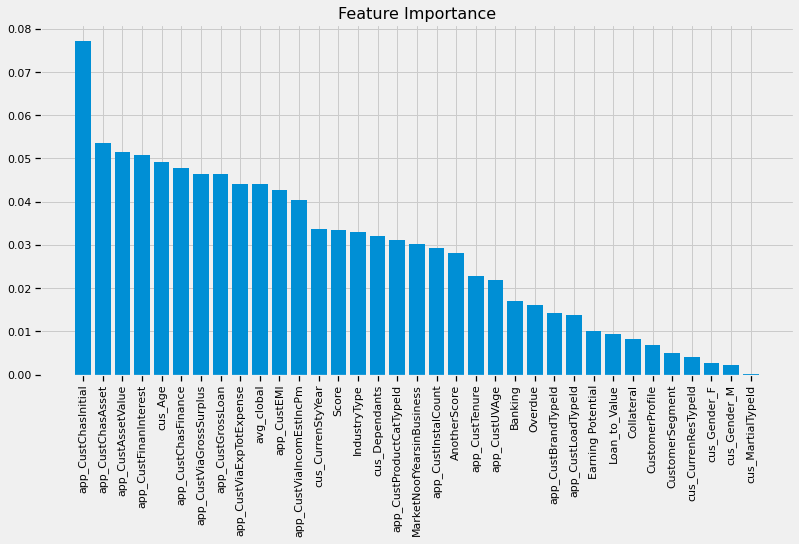

In [66]:
# Plot features importance
importances = best_rf.feature_importances_
indices = np.argsort(best_rf.feature_importances_)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, 36), importances[indices], align="center")
plt.xticks(range(1, 36), df.columns[df.columns != "Label"][indices], rotation=90)
plt.title("Feature Importance", {"fontsize": 16})
plt.savefig('fi_cv.jpg', bbox_inches='tight')

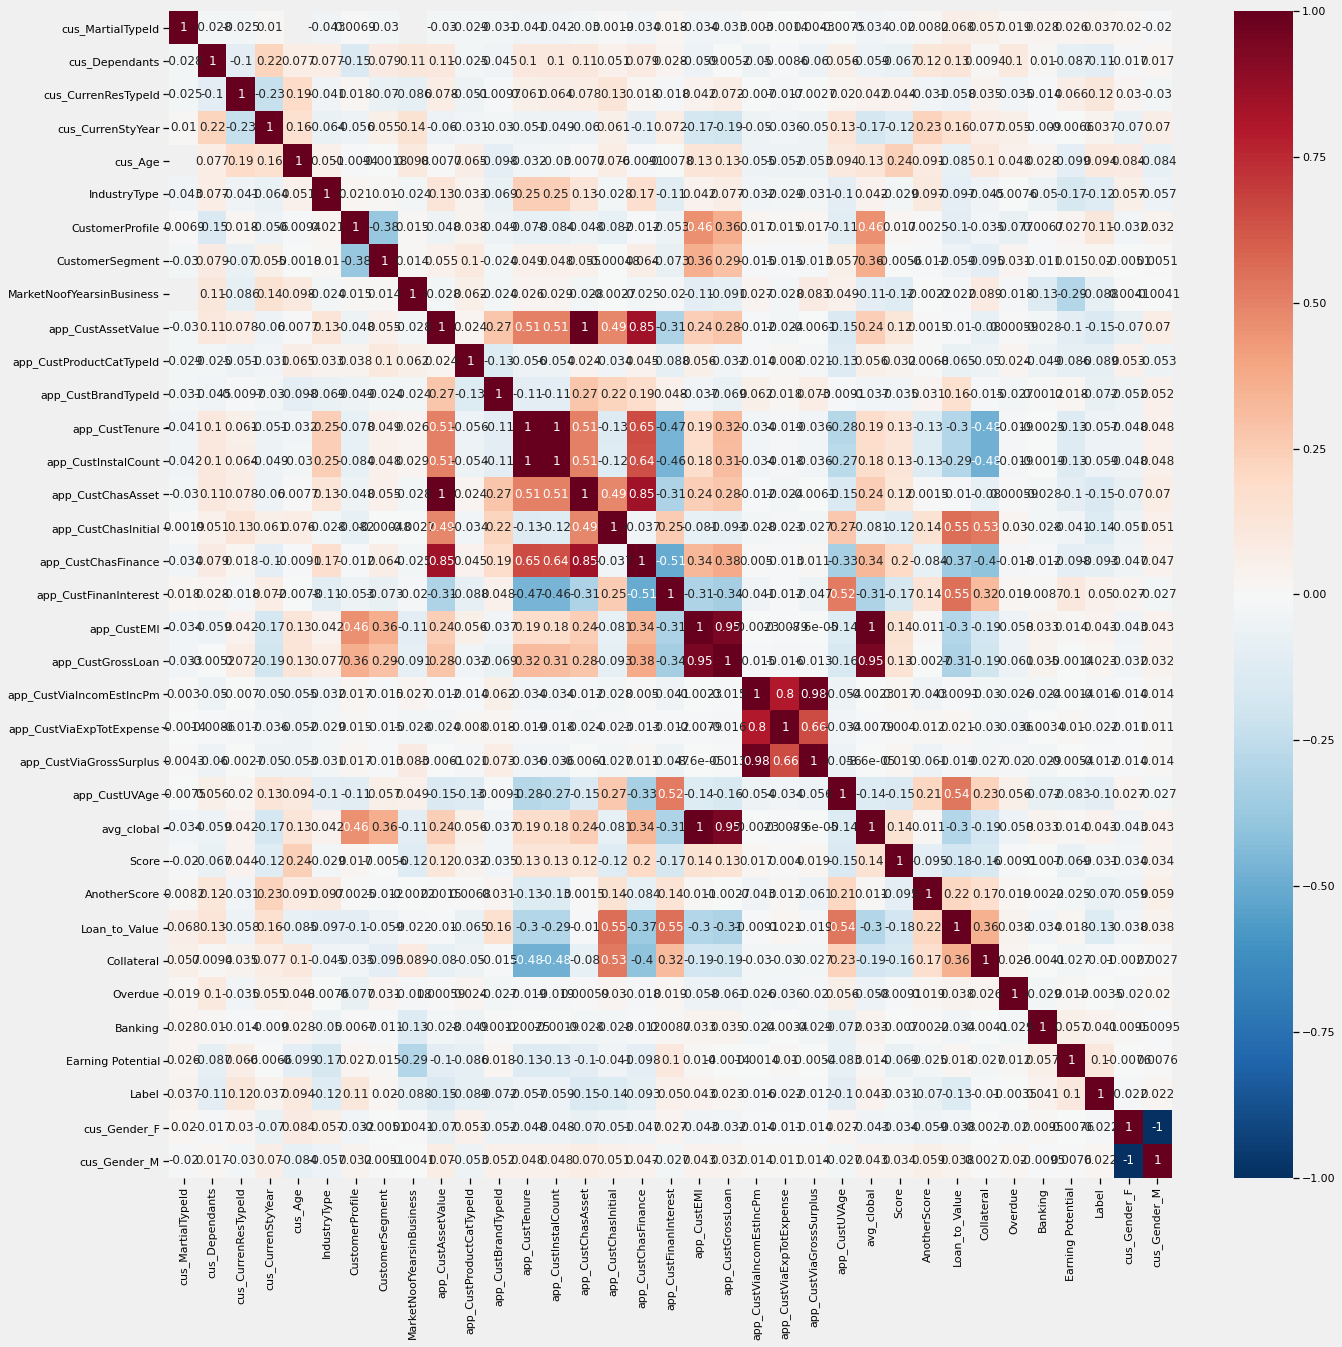

In [67]:
#Using Pearson Correlation
plt.figure(figsize=(20,20))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.RdBu_r)
plt.show()

In [68]:
cor['Label']

cus_MartialTypeId            0.037304
cus_Dependants              -0.107538
cus_CurrenResTypeId          0.115349
cus_CurrenStyYear            0.037171
cus_Age                      0.094278
IndustryType                -0.123536
CustomerProfile              0.111429
CustomerSegment              0.019789
MarketNoofYearsinBusiness   -0.087586
app_CustAssetValue          -0.146566
app_CustProductCatTypeId    -0.088794
app_CustBrandTypeId         -0.071877
app_CustTenure              -0.057244
app_CustInstalCount         -0.058925
app_CustChasAsset           -0.146566
app_CustChasInitial         -0.135499
app_CustChasFinance         -0.093313
app_CustFinanInterest        0.050252
app_CustEMI                  0.042926
app_CustGrossLoan            0.022977
app_CustViaIncomEstIncPm    -0.016012
app_CustViaExpTotExpense    -0.022254
app_CustViaGrossSurplus     -0.012278
app_CustUVAge               -0.104288
avg_clobal                   0.042926
Score                       -0.030669
AnotherScore